In [1]:
%matplotlib inline

In [2]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import random as py_random
import numpy.random as np_random
import pandas as pd
from tabulate import tabulate
import math
from scipy.stats import norm
from scipy.stats import lognorm
import statsmodels.api as sm

from io import StringIO
import requests
import re
from matplotlib.ticker import FuncFormatter



sns.set(style="whitegrid")

# You may load the dataset from URL (instead of the local file) if you wish
auto_mpg_data = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt"
auto_mpg_names = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.names.txt"

<a id="contents"></a>
# Contents

1. [ETL](#step1)
2. [EDA](#step2)
3. [Statistical and Mathematical Modeling of the Target Variable](#step3)

## 1.1 <a id="step1">ETL</a>
<a href="#contents">^ Contents</a>

The first step is to load the data from its remote location into a dataframe and make sure we have the data.

In [3]:
# Replace 'your_url_here' with the actual URL of your text file
url = 'https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt'
response = requests.get(url)
data = StringIO(response.text)
data_content = data.getvalue().replace('\t', '  ')
data_cleaned = StringIO(data_content)

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model_Year', 'Origin', 'Car_Name']

df = pd.read_csv(data_cleaned, names=column_names, quotechar='"', delimiter='\s\s+', engine='python')
df = df[df['Horsepower'] != '?']
df['Horsepower'] = pd.to_numeric(df['Horsepower'], errors='coerce')
df['Car_Name'] = df['Car_Name'].astype("string")

df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Origin,Car_Name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino"""


We confirm that we have correctly loaded the data into a dataframe. We also note that we removed several rows that had no values for Horsepower to make things easier during our EDA.

Now let's see some information about each of the rows.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model_Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
 8   Car_Name      392 non-null    string 
dtypes: float64(5), int64(3), string(1)
memory usage: 30.6 KB


We see that we have 392 entries for each variable so there are no missing values. There are 5 floating point columns (continuous), 3 integer columns (multi-valued discrete) and 1 string column.

Based on our domain knowledge, we generate the following causal loop diagram.

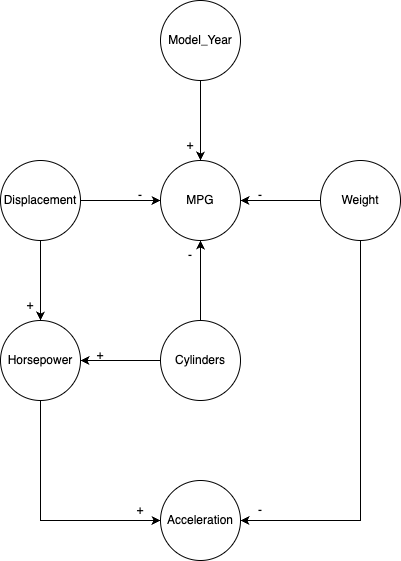

We hypothesize that Displacement, Weight and Cylinders will increase the MPG, while increasing Model_Year will decrease MPG. We predict that Displacement and Cylinders will both increase Horsepower, which will in turn increase Acceleration. We predict that Weight will also decrease Acceleration. This is our initial understanding of the causal loop represented by the data, and we will expand on our understanding as our EDA progresses.

In [5]:
def freeman_diaconis(data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int(np.ceil(h))

In [6]:
def histogram_w_whiskers(data, variable_name, zoom=None):
    h = freeman_diaconis(data[variable_name])
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range( mn, mx, h)]
    print(f"Freeman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()
        
    # start the plot: 2 rows, because we want the boxplot on the first row
    # and the hist on the second
    fig, ax = plt.subplots(
        2, figsize=(7, 5), sharex=True,
        gridspec_kw={"height_ratios": (.7, .3)}  # the boxplot gets 30% of the vertical space
    )

    # the histogram
    ax[0].hist(data[variable_name],bins=bins, color="dimgray", weights=empirical_weights)
    ax[0].set_title(f"{variable_name} distribution - Freeman Diaconis")
    ax[0].set_ylabel("Relative Frequency")
    if zoom:
        ax[0].set_ylim((0, zoom))
    # the box plot
    ax[1].boxplot(data[variable_name], vert=False)
    # removing borders
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].set_xlabel(variable_name)

    # and we are good to go
    plt.show()
    plt.close()
    return h

In [7]:
def histogram_trio(data, variable_name, zoom=1.0):
    h = freeman_diaconis(data[variable_name])
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range( mn, mx, h)]
    print(f"Freeman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()

    fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

    fewer_bins = int(len(bins) * .50)
    more_bins = int(len(bins) * 2)

    n, bins, patches = ax[1].hist(data[variable_name], color="DimGray", bins=bins, weights=empirical_weights) # <---
    ax[1].set_xlabel(variable_name)
    ax[1].set_ylabel("Relative Frequency")
    ax[1].set_title(f"Relative Frequency Histogram of {variable_name}")
    ax[1].set_ylim((0, zoom))
    
    n, bins, patches = ax[0].hist(data[variable_name], color="DimGray", bins=fewer_bins, weights=empirical_weights)
    ax[0].set_xlabel(variable_name)
    ax[0].set_ylabel("Relative Frequency")
    ax[0].set_title(f"Relative Frequency Histogram of {variable_name} (Fewer Bins)")
    
    n, bins, patches = ax[2].hist(data[variable_name], color="DimGray", bins=more_bins, weights=empirical_weights)
    ax[2].set_xlabel(variable_name)
    ax[2].set_ylabel("Relative Frequency")
    ax[2].set_title(f"Relative Frequency Histogram of {variable_name} (More Bins)")

    plt.show()
    plt.close()

## 1.2 <a id="step2">EDA</a>

## Single Variable EDA

We'll start our EDA by looking at each variable individually, starting with the target variable, *MPG*.

<a href="#MPG">MPG</a><br>
<a href="#Cylinders">Cylinders</a><br>
<a href="#Displacement">Displacement</a><br>
<a href="#Horsepower">Horsepower</a><br>
<a href="#Weight">Weight</a><br>
<a href="#Acceleration">Acceleration</a><br>
<a href="#Model_Year">Model_Year</a><br>
<a href="#Origin">Origin</a><br>
<a href="#Car_Name">Car_Name</a><br>

<a id="MPG"></a>
## MPG

The MPG variable is our target variable in our EDA. It is a continuous numerical variable measured in number of miles per gallon.

MPG is a common statistic for cars to measure their efficiency. It is the number of miles a car can travel consuming a single gallon of gas. Most car manufacturers strive to make cars that have higher MPG ratings. There is a tradeoff between car performance and car MPG.

We predict the MPG of cars will range from approximately 10 to 35.

First we get some preliminary summary statistics of our data.

In [8]:
df.MPG.describe()

count    392.000000
mean      23.445918
std        7.805007
min        9.000000
25%       17.000000
50%       22.750000
75%       29.000000
max       46.600000
Name: MPG, dtype: float64

The summary statistics mostly support our hypothesis. The mean is 23.5 and the median is 22.8. The 3rd quartile is 29.0. The minimum is 9.0 while the maximum is 46.6. This range includes far higher MGP values than we expected.

Let's also look at the count of cars for each MPG value.

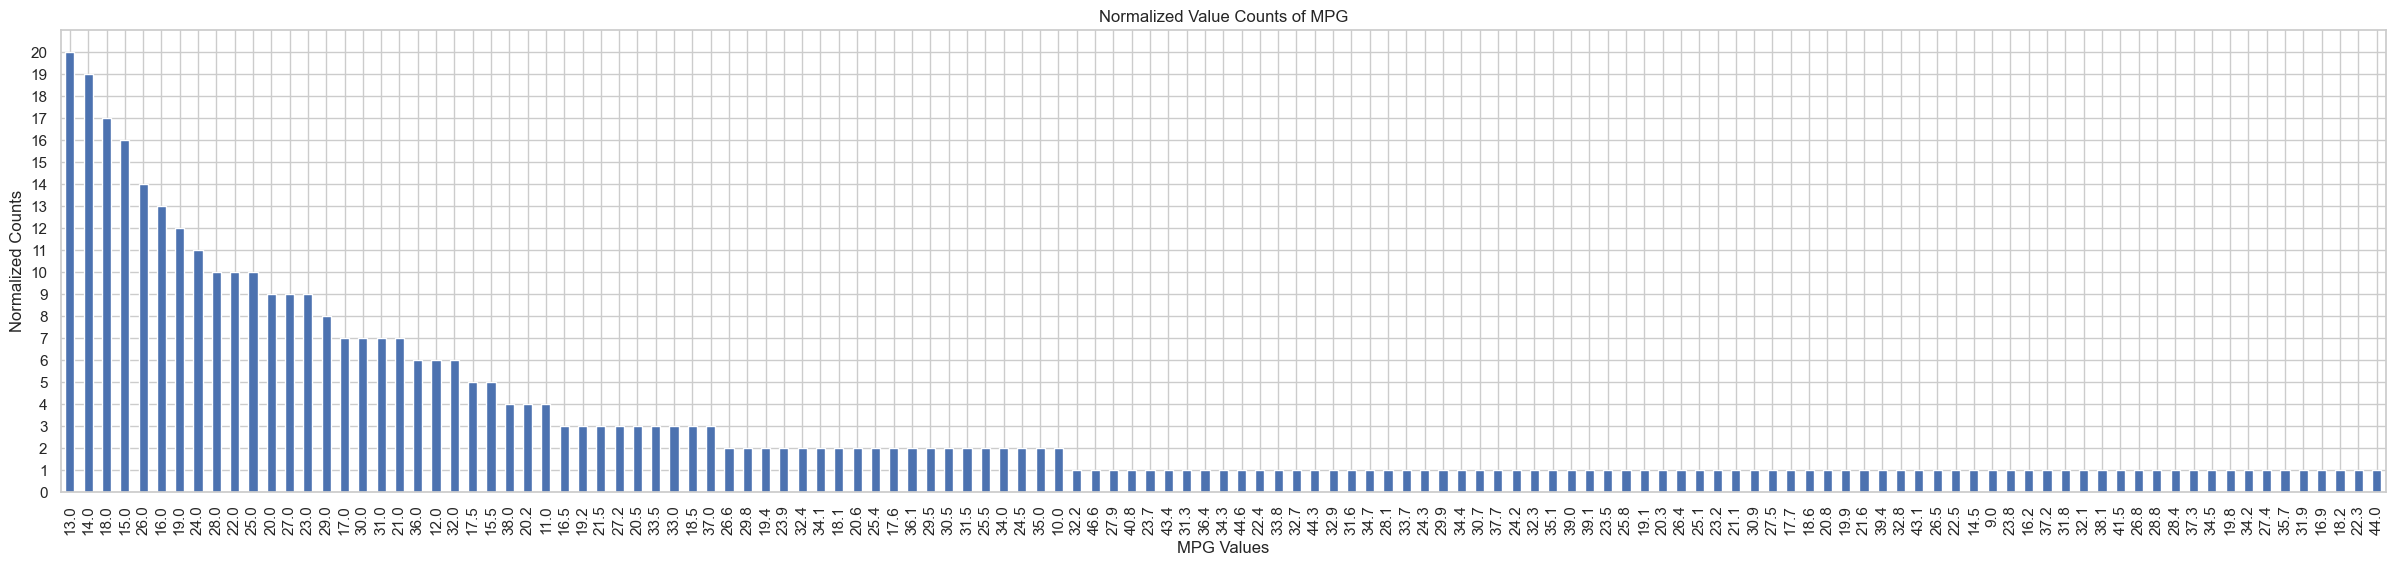

In [9]:
df_value_counts = df.MPG.value_counts()

plt.figure(figsize=(30, 6))
df_value_counts.plot(kind='bar')
plt.title('Normalized Value Counts of MPG')
plt.xlabel('MPG Values')
plt.ylabel('Normalized Counts')
plt.yticks(np.linspace(0, max(df_value_counts), num=max(df_value_counts) + 1))  # Adjust the number of ticks as needed
plt.show()

We see that the most common MPG values are 13 and 14, which appear 20 and 19 times respectively. We also see that there are many MPG values that only appear for one car.

Now we visualize the distribution. We expect to see a distribution that is concentrated to the left and with fewer larger values.

Freeman Diaconis for MPG: 10 bins


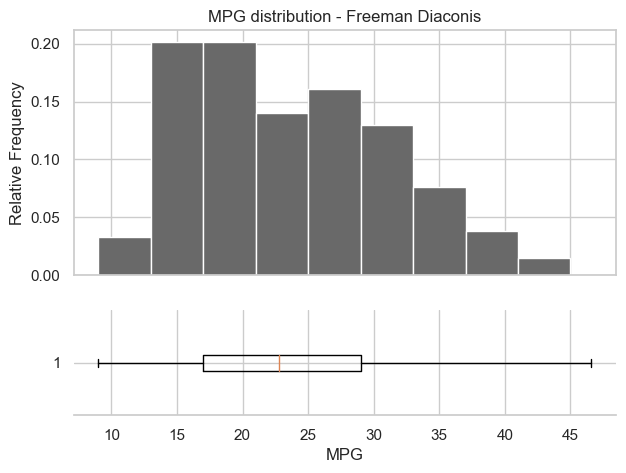

In [10]:
MPG_bins = histogram_w_whiskers(df, "MPG")

As we predicted we can see the data is concentrated to the left with fewer larger values to the right. The box and whiskers plot shows the median is right around 23, which is consistent with our preliminary descriptive statistics.

Now we try using different numbers of bins to see if we can gain any new insight.

Freeman Diaconis for MPG: 10 bins


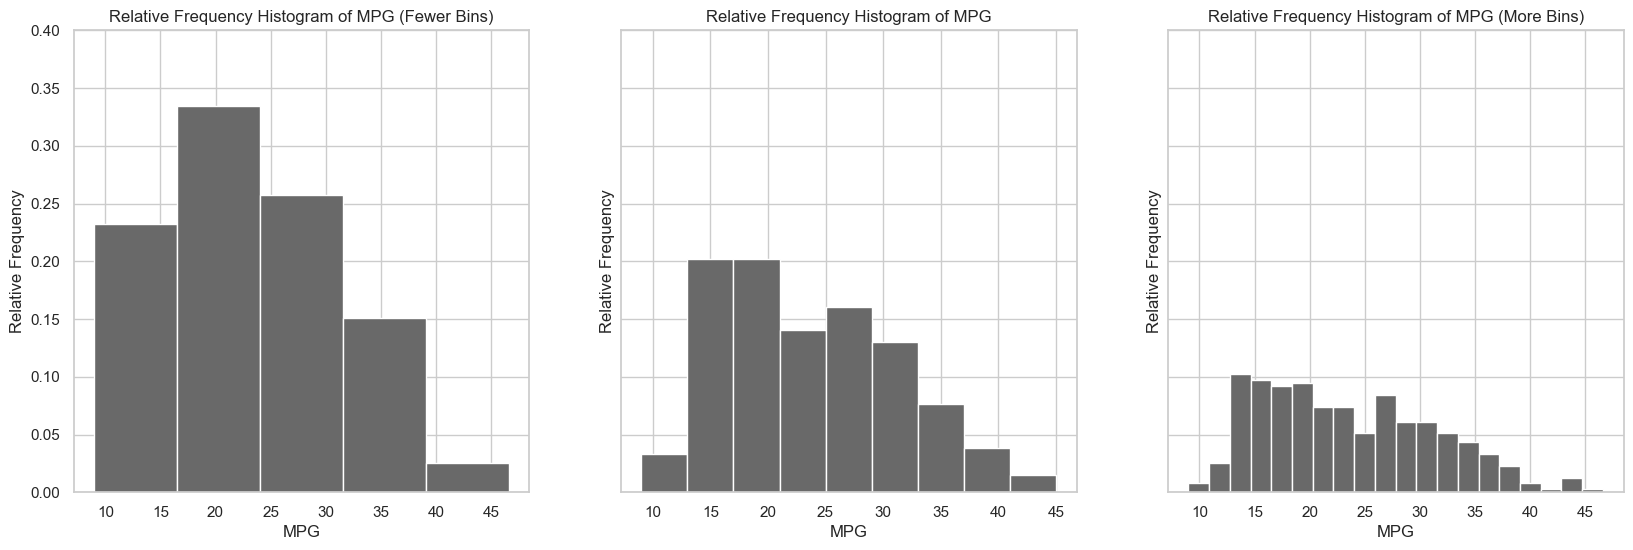

In [11]:
histogram_trio(df, "MPG", zoom=0.4)

After using different numbers of bins, we see that the overall shape of the data remains consistent. We do notice a couple of relatively extreme values to the right, just shy of 45 mpg. These aren't outliers however as they are still within the realm of possibility.

In summary, we found that MPG values are in the range of 9 to 46, with most being smaller and relatively few being close to 46.

1. These MPG values seem a good bit lower than the average car nowadays, which should be expected.
2. As a result, we expect MPG to increase as model_year increases.
3. It is surprising that some cars achieved up to 46 MPG in the 1970s.

<a id="Cylinders"></a>
## Cylinders

The Cylinders variable is a multi-valued discrete numerical variable measured in number of cylinders in the engine.

A cylinder is a chamber in the engine where fuel is combusted to create power. The cylinder consists of a piston and two valves at the top; an inlet and exhaust valve. Generally, the more cylinders an engine has, the more power it produces. Most cars have either 4, 6 or 8 cylinders in their engine.

Data Source: [kia.com](https://www.kia.com/dm/discover-kia/ask/what-is-a-cylinder-in-a-car.html#:~:text=Generally%2C%20the%20more%20cylinders%20your,6%2C%20or%208%20cylinder%20engine.)
Retrieved on November 13, 2023.

We predict the number of cylinders will be either 4, 6 or 8. Let's check if this is true.

In [12]:
df.Cylinders.value_counts(normalize=True)

4    0.507653
8    0.262755
6    0.211735
3    0.010204
5    0.007653
Name: Cylinders, dtype: float64

Interestingly, we find that our hypothesis was almost but not completely correct. While a large majority of cars have 4, 6 or 8 cylinders, there are also some that have 3 or 5 cylinders.

Now we visualize the distribution. We expect to see a distribution that is concentrated at 4 on the left and with fewer larger values.

Freeman Diaconis for Cylinders: 3 bins


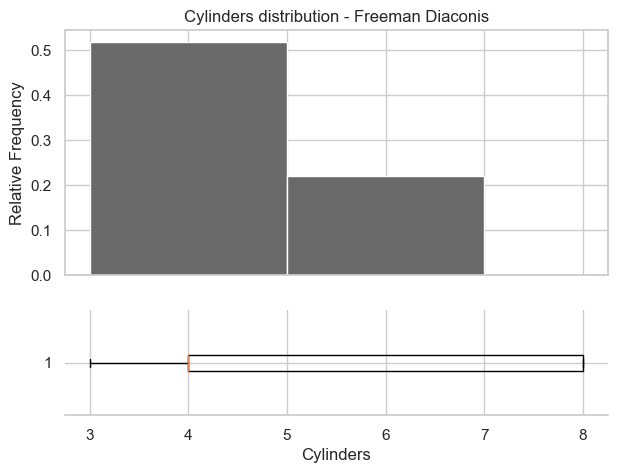

In [13]:
Cylinders_bins = histogram_w_whiskers(df, "Cylinders")

Our histogram binning algorithm as created 3 bins, but these bins don't do a good job at helping us visualize the distribution of the Cylinders variable.

Now we try using different numbers of bins to see if we can gain any new insight.

Freeman Diaconis for Cylinders: 3 bins


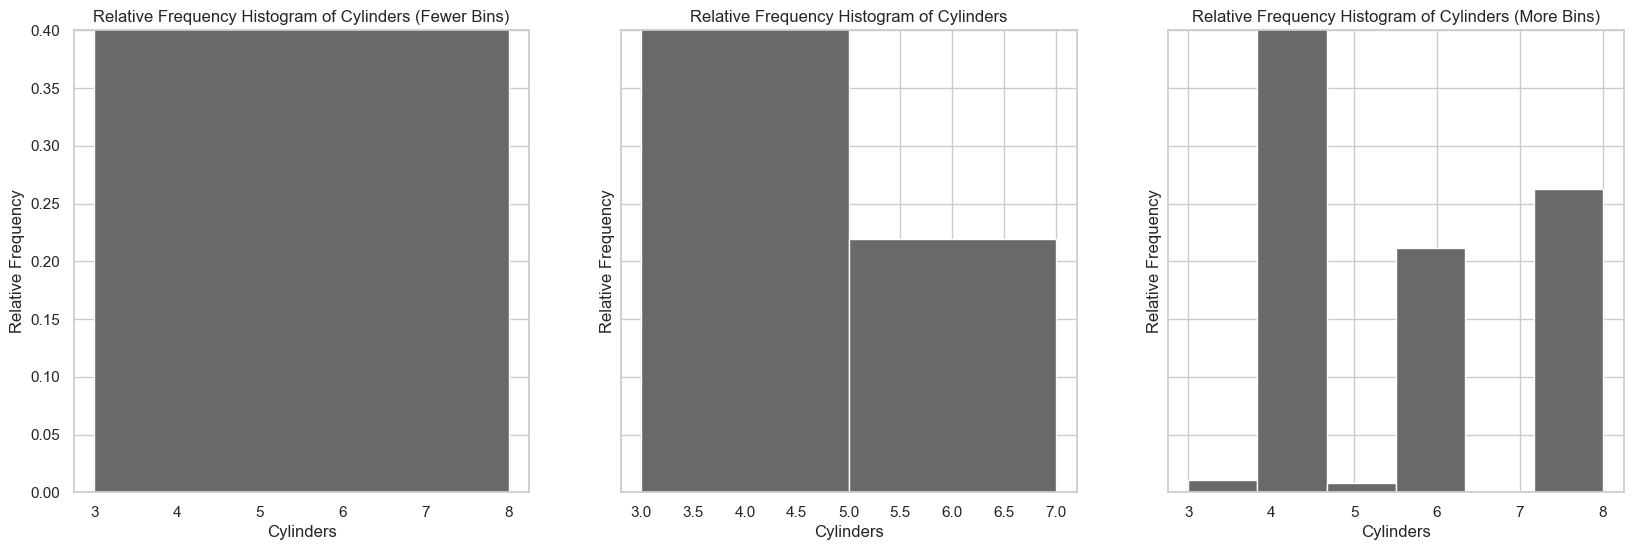

In [14]:
histogram_trio(df, "Cylinders", zoom=0.4)

We get a much better view of our results using more bins. Our third histogram on the right shows what we want. We see that a large majority of car engines have 4 cylinders, followed by 8 and then 6. We also see the few that have 3 or 5 cylinders.

In summary, we found that Cylinders values are in the range 3-8, with a majority having 4, 6 or 8 cylinders and only a few having 3 or 5 cylinders, and none having 7.

1. Why do so few car engines use 3 and 5 cylinders?
2. Is it simply not a standard? Or is there something advantageous about having an even number of cylinders?
3. There are a surprising number of 8 cylinder cars. I thought most cars nowadays have 4 cylinders unless they are large or are purpose-built performance vehicles.

<a id="Displacement"></a>
## Displacement

The Displacement variable is a continuous numerical variable measured in cubic inches (ci).

Displacement is a common car statistic, and it is the measure of the cylinder volume swept by all of the pistons in a piston engine. It is commonly used as an expression of the engine's size, and a loose indicator of the power of the engine. It is also used as an indicator of the amount of fuel an engine is expected to consume.

Data Source: [wikipedia.org](https://en.wikipedia.org/wiki/Engine_displacement)
Retrieved on November 13, 2023.


We predict the Displacement of cars will range from approximately 100 to 500 cubic inches.

First we get some preliminary summary statistics of our data.

In [15]:
df.Displacement.describe()

count    392.000000
mean     194.411990
std      104.644004
min       68.000000
25%      105.000000
50%      151.000000
75%      275.750000
max      455.000000
Name: Displacement, dtype: float64

The summary statistics support our hypothesis. The mean is 194 and the median is 151. The 3rd quartile is 275. The minimum is 68 while the maximum is 455. This range is very close to our predicted range.

Now we visualize the distribution. We expect to see a distribution that is concentrated to the left and with fewer larger values.

Freeman Diaconis for Displacement: 8 bins


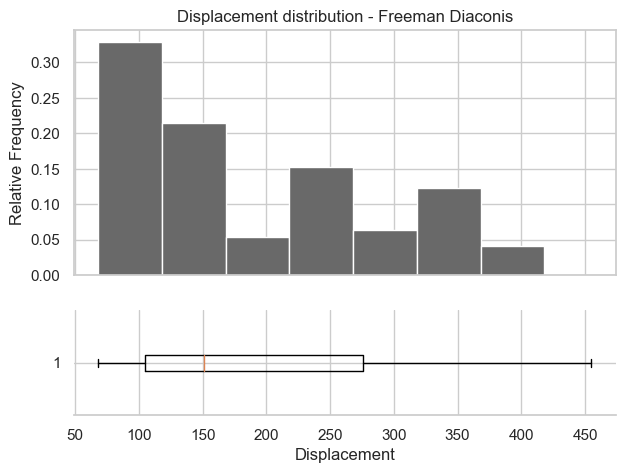

In [16]:
Displacement_bins = histogram_w_whiskers(df, "Displacement")

As we predicted we can see the data is concentrated to the left with fewer larger values to the right. The box and whiskers plot shows the median is right around 151, which is consistent with our preliminary descriptive statistics.

Now we try using different numbers of bins to see if we can gain any new insight.

Freeman Diaconis for Displacement: 8 bins


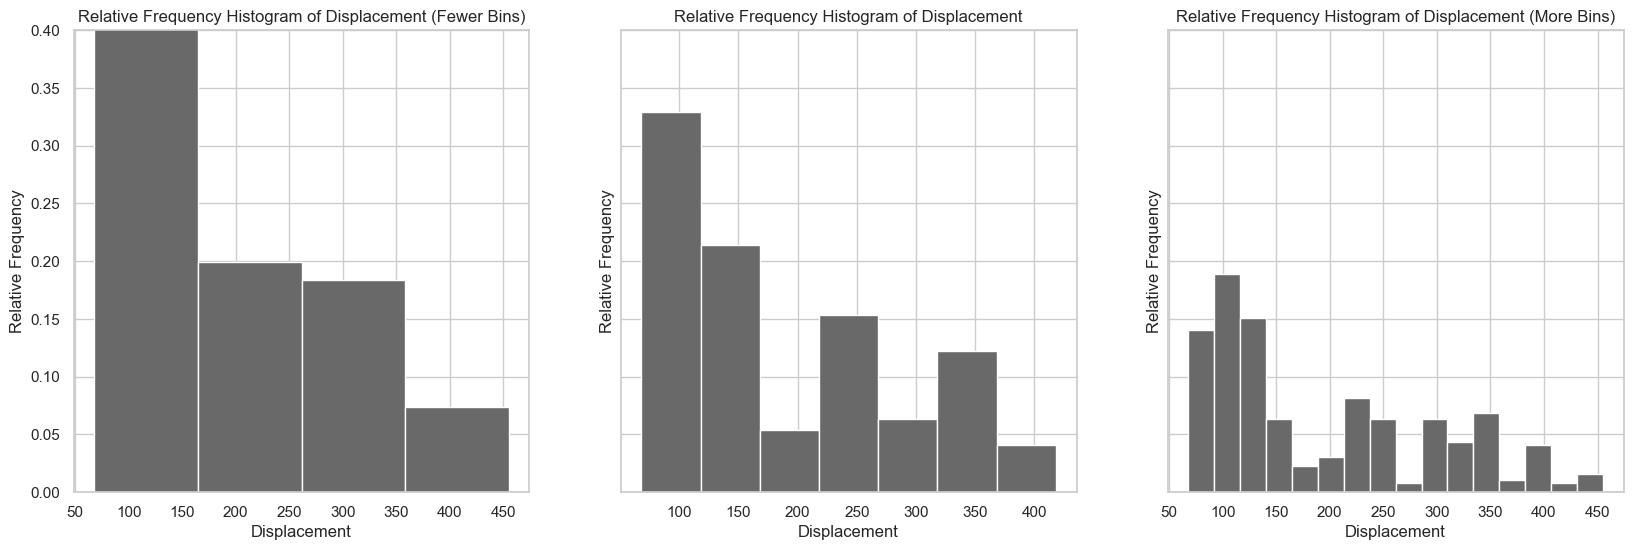

In [17]:
histogram_trio(df, "Displacement", zoom=0.4)

After using different numbers of bins, we see that the overall shape of the data remains consistent. We notice that there are groups of higher concentration around 250 and 350 ci. It is possible that this is the result of certain volumes being used by the same manufacturer or maybe a volume that is popular among different manufacturers as well.

In summary, we found that Displacement values are in the range of 68 to 455, with most being smaller and relatively few being close to 455.

1. Displacement should be directly correlated with number of cylinders.
2. The data is using all imperial units, and thus uses cubic inches, but most cars nowadays are marketed with displacements in Liters.
3. Displacement is a common car marketing metric.

<a id="Horsepower"></a>
## Horsepower

The Horsepower variable is a continuous numerical variable measured in the power unit of Horsepower.

Horsepower refers to the power an engine produces. It is calculated through the pwoer needed to move 550 pounds one foot in one second or by the power needed to move 33,000 pounds one foot in one minute. The power is gauged by the rate it takes to do the work.

Data Source: [toyota.ca](https://www.toyota.ca/toyota/en/connect/3887/what-is-horsepower#:~:text=Horsepower%20refers%20to%20the%20power,one%20foot%20in%20one%20minute.)
Retrieved on November 13, 2023.


We predict the Horsepower of cars will range from approximately 100 to 400 horsepower.

First we get some preliminary summary statistics of our data.

In [18]:
df.Horsepower.describe()

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: Horsepower, dtype: float64

The summary statistics partially support our hypothesis. The mean is 104 and the median is 93. The 3rd quartile is 126. The minimum is 46 while the maximum is 230. This range is a little bit off from our predicted range of 100 to 400 HP.

Now we visualize the distribution. We expect to see a distribution that is concentrated to the left and with fewer larger values.

Freeman Diaconis for Horsepower: 13 bins


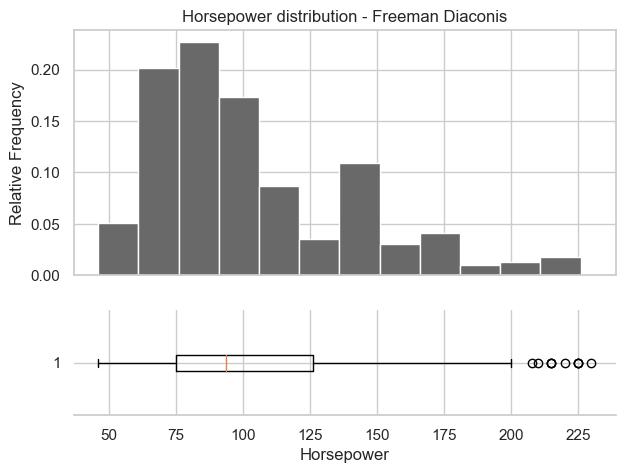

In [19]:
Displacement_bins = histogram_w_whiskers(df, "Horsepower")

As we predicted we can see the data is concentrated to the left with fewer larger values to the right. The box and whiskers plot shows the median is right around 93, which is consistent with our preliminary descriptive statistics.

Now we try using different numbers of bins to see if we can gain any new insight.

Freeman Diaconis for Horsepower: 13 bins


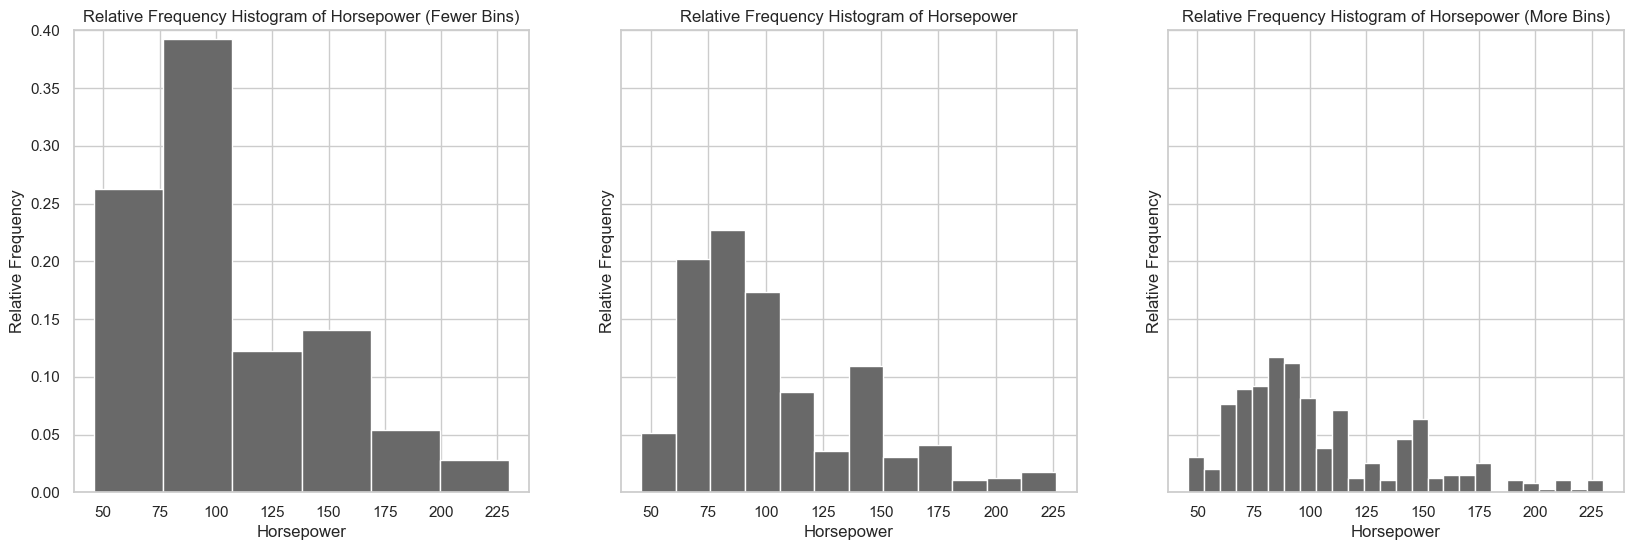

In [20]:
histogram_trio(df, "Horsepower", zoom=0.4)

After using different numbers of bins, we see that the overall shape of the data remains consistent. We notice a slight concentration of values around the 150 horsepower mark. This seems to have been a popular choice of horsepower at the time.

In summary, we found that Horsepower values are in the range of 46 to 230, with most being smaller and relatively few being close to 230.

1. Horsepower is often sought at the expense of fuel efficiency.
2. Why is there a spike in values around 150 horsepower?
3. It is interesting to see how low the horsepower values were in 1970, whereas nowadays anything below 150 horsepower may be considered low.

<a id="Weight"></a>
## Weight

The Weight variable is a continuous numerical variable measured in pounds.

Weight has important implications in terms of the acceleration of the car, from Newton's Second law of motion: $Force = mass \times acceleration$, which we can rearrange as $acceleration = \frac{Force}{mass}$. In other words, the more mass a car has, the slower it will accelerate.

We predict the Weight of cars will range from approximately 1500 to 3000 pounds.

First we get some preliminary summary statistics of our data.

In [21]:
df.Weight.describe()

count     392.000000
mean     2977.584184
std       849.402560
min      1613.000000
25%      2225.250000
50%      2803.500000
75%      3614.750000
max      5140.000000
Name: Weight, dtype: float64

The summary statistics partially support our hypothesis. The mean is 2977 and the median is 2803. The 3rd quartile is 3614. The minimum is 1613 while the maximum is 5140. This range is a little bit off from our predicted range of 1500 to 3000 pounds, as the car weights exceed this range.

Now we visualize the distribution. We expect to see a distribution that is concentrated to the left and with fewer larger values.

Freeman Diaconis for Weight: 10 bins


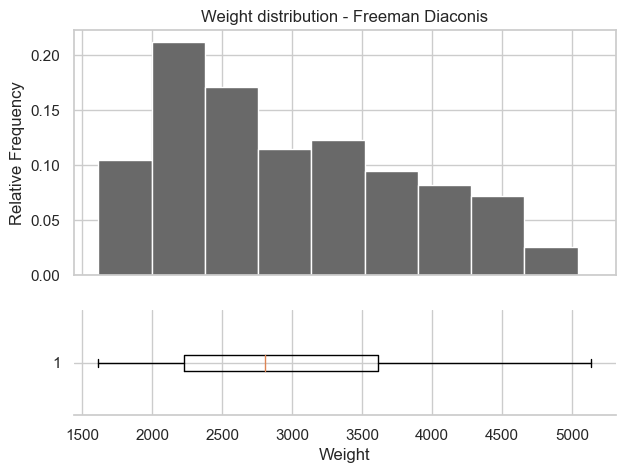

In [22]:
Displacement_bins = histogram_w_whiskers(df, "Weight")

As we predicted we can see the data is concentrated to the left with fewer larger values to the right. The box and whiskers plot shows the median is right around 2803, which is consistent with our preliminary descriptive statistics.

Now we try using different numbers of bins to see if we can gain any new insight.

Freeman Diaconis for Weight: 10 bins


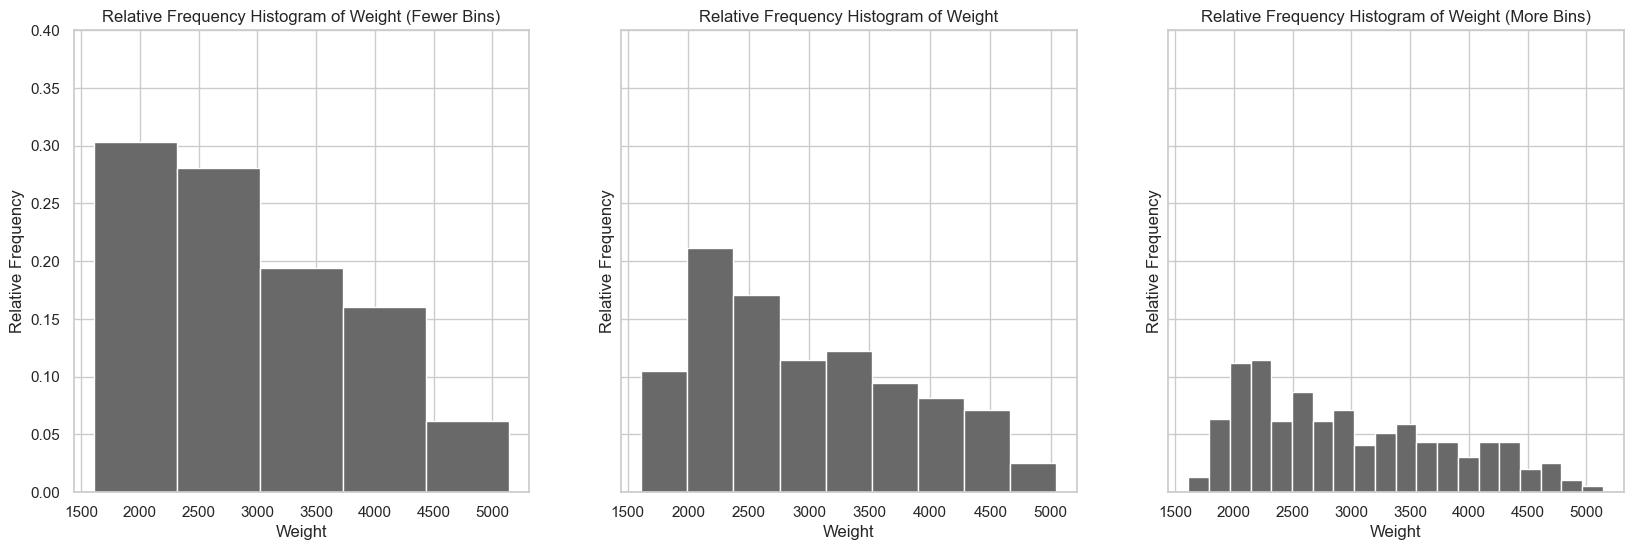

In [23]:
histogram_trio(df, "Weight", zoom=0.4)

After using different numbers of bins, we see that the overall shape of the data remains consistent. We don't notice any other significant trends.

In summary, we found that Weight values are in the range of 1613 to 5140, with most being smaller and relatively few being close to 5140.

1. The weight of a car will increase with a larger engine.
2. However, there are many components in a car that will contribute to it's weight, such as interior stylings and overall size/passenger capacity.
3. The weight should directly correlate to the acceleration.

<a id="Acceleration"></a>
## Acceleration

The Acceleration variable is a continuous numerical variable measured in feet/second squared (ft/s^2).

The Acceleration of a car is important for safety when merging, as well as for driver experience.

We predict the Acceleration of cars will range from approximately 10 to 50 ft/s^2.

First we get some preliminary summary statistics of our data.

In [24]:
df.Acceleration.describe()

count    392.000000
mean      15.541327
std        2.758864
min        8.000000
25%       13.775000
50%       15.500000
75%       17.025000
max       24.800000
Name: Acceleration, dtype: float64

The summary statistics partially support our hypothesis. The mean is 15.5 and the median is 15.5. The 3rd quartile is 17. The minimum is 8.0 while the maximum is 24.8. This range is a little bit off from our predicted range of 10 to 50 ft/s^2.

Now we visualize the distribution. Once again, we expect to see a distribution that is concentrated to the left and with fewer larger values.

Freeman Diaconis for Acceleration: 16 bins


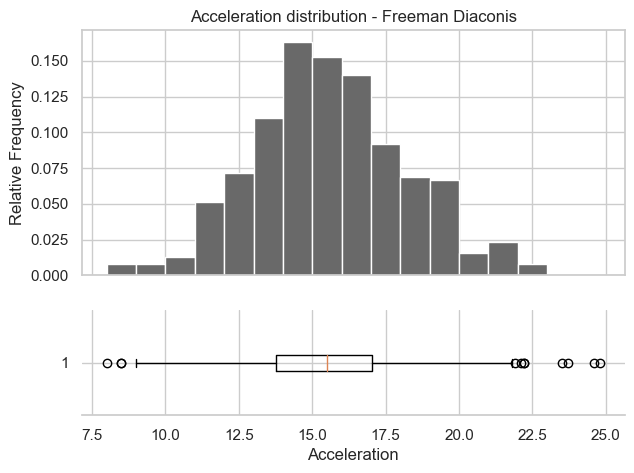

In [25]:
Displacement_bins = histogram_w_whiskers(df, "Acceleration")

Interestingly, the Acceleration variable does not seem to be skewed in either direction. Instead, it seems balanced from left to right, and isn't concentrated to the left or right. The box and whiskers plot shows the median is right around 15, which is consistent with our preliminary descriptive statistics.

Now we try using different numbers of bins to see if we can gain any new insight.

Freeman Diaconis for Acceleration: 16 bins


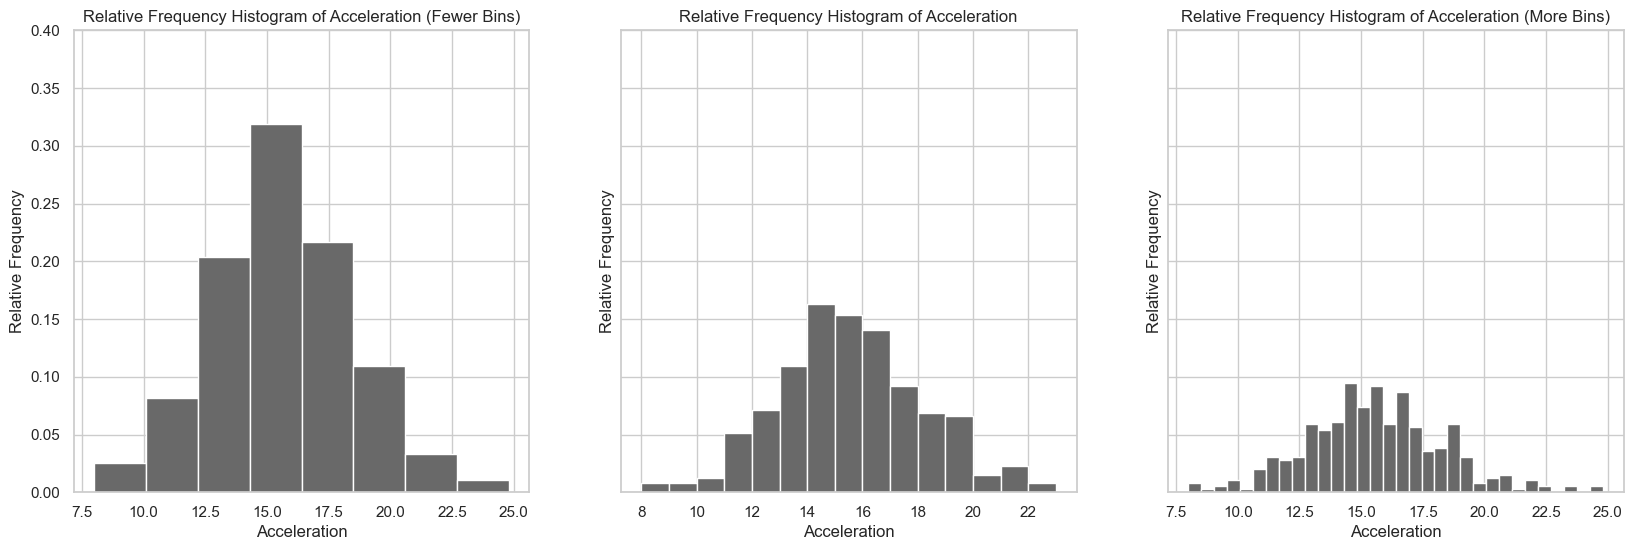

In [26]:
histogram_trio(df, "Acceleration", zoom=0.4)

After using different numbers of bins, we see that the overall shape of the data remains consistent. We don't notice any other significant trends.

In summary, we found that Acceleration values are in the range of 8.0 to 24.8, with a relatively symmetrical distribution.

1. The distribution of the results for acceleration is different from the other variables in that it is mostly symmetrical.
2. The acceleration of a car has several factors contributing to it, such as mass, horsepower, and drag. We do not have any data on drag for these cars.
3. Acceleration is likely correlated to these factors, and will probably have a somewhat strong correlation to MPG but may not be directly correlated.

<a id="Model_Year"></a>
## Model_Year

The Model_Year variable is a discrete numerical variable measured in the last two digits of the year the car was made. For example, if the car was made in 1970, the Model_Year value would be 70.

After seeing our preliminary statistics, we predict most car years will be around 70.

First we get some preliminary summary statistics of our data.

In [27]:
df.Model_Year.describe()

count    392.000000
mean      75.979592
std        3.683737
min       70.000000
25%       73.000000
50%       76.000000
75%       79.000000
max       82.000000
Name: Model_Year, dtype: float64

It seems that 70 is the earliest year in the data. The mean is 75 and the median is 76. The 3rd quartile is 79. The minimum is 70 while the maximum is 82.

Now we visualize the distribution. Here we expect a relatively even distribution, meaning the histogram will appear uniform and flat.

Freeman Diaconis for Model_Year: 6 bins


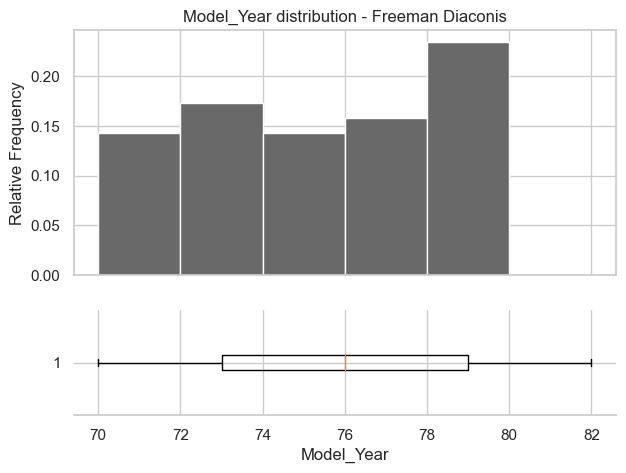

In [28]:
Displacement_bins = histogram_w_whiskers(df, "Model_Year")

As we expected, the distribution appears flat. The exception is the last bin, which shows a slight concentration of values between 78 and 80. The box and whiskers plot shows the median is right around 76, which is consistent with our preliminary descriptive statistics.

Now we try using different numbers of bins to see if we can gain any new insight.

Freeman Diaconis for Model_Year: 6 bins


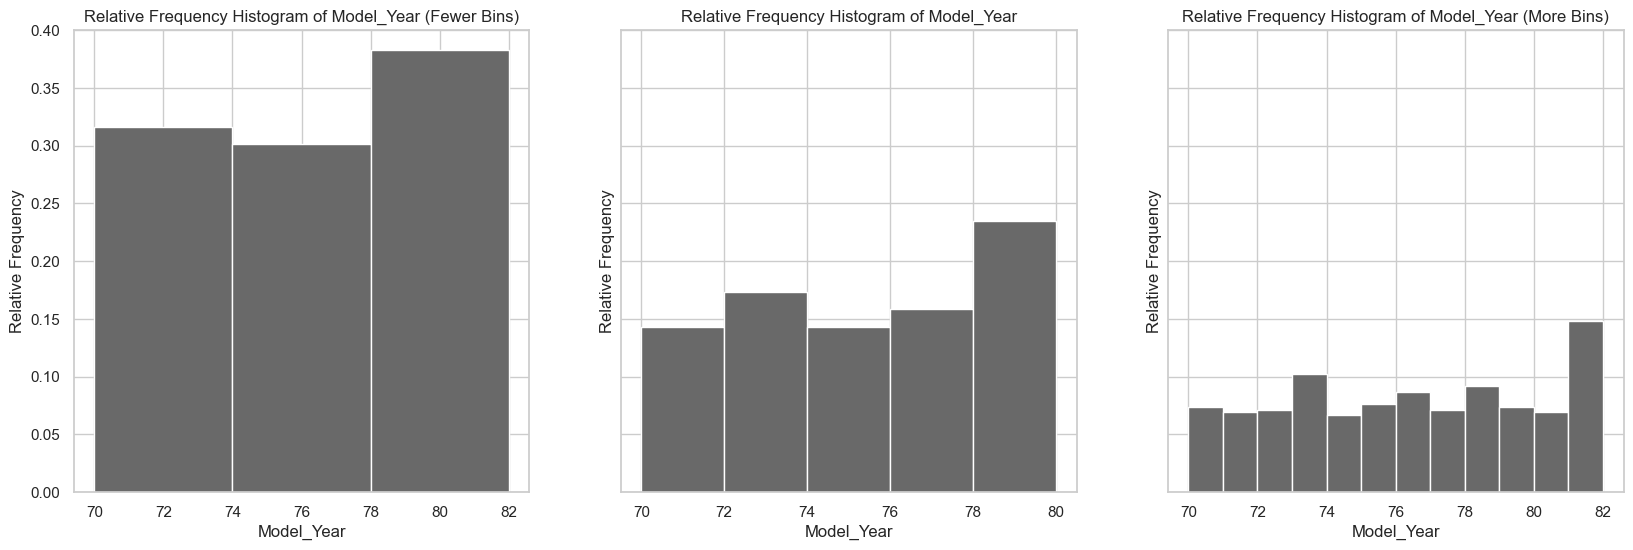

In [29]:
histogram_trio(df, "Model_Year", zoom=0.4)

After using different numbers of bins, we see that the overall shape of the data remains consistent. The main trend that we notice is that there is a higher concentration at 82.

Let's see the value counts.

In [30]:
df.Model_Year.value_counts()

73    40
78    36
76    34
75    30
82    30
70    29
79    29
72    28
77    28
81    28
71    27
80    27
74    26
Name: Model_Year, dtype: int64

It seems that the largest percentage of cars are from 73, followed by 78 and 76. The rest of the years are pretty evenly distributed with close to 30 instances each.

In summary, we found that Model_Year values are in the range of 70 to 82, with a relatively flat distribution.

1. The cars in our data come from a limited window of years, so any analysis we do is based on this timeframe.
2. It is unclear why there is a spike in values for the years 73, 76 and 78.
3. It is also unclear how cars were selected for the data, which may have resulted in a different number of cars for each year.

<a id="Car_Name"></a>
## Car_Name

The Car_Name variable is a categorical variable with many values. These values are strings of the name of the car.

Here are the relative frequencies.

In [31]:
df.Car_Name.value_counts(normalize=True)

"amc matador"             0.012755
"toyota corolla"          0.012755
"ford pinto"              0.012755
"toyota corona"           0.010204
"amc hornet"              0.010204
                            ...   
"ford fairmont"           0.002551
"vw dasher (diesel)"      0.002551
"vw rabbit c (diesel)"    0.002551
"mazda glc"               0.002551
"chevy s-10"              0.002551
Name: Car_Name, Length: 301, dtype: Float64

We observe that there are many different Car_Name values, and they seem to be pretty evenly represented. The most common cars in the data are the AMC Matador and the Toyota Corolla.

1. Are certain car models more fuel efficient than others?
2. It seems that there are a handful of car models that are more popular than the others.
3. We would need to do more heavy processing of this variable to extract the manufacturer if we wanted to analyze the relationship between manufacturer and MPG.

<a id="Origin"></a>
## Origin

The Origin variable is a discrete variable with values 1, 2 and 3. 1 corresponds to cars made in the USA, 2 for Europe and 3 for Asia.

We predict that a majority of cars were made in the USA, since this dataset is from the 1970s.

Here are the relative frequencies.

In [32]:
df.Origin.value_counts(normalize=True)

1    0.625000
3    0.201531
2    0.173469
Name: Origin, dtype: float64

Our hypothesis was correct, as a majority 62% of cars were made in the USA, while 20% were made in Asia and 17 percent were made in Europe. It will be interesting to see how this variable effects MPG.

1. Which country of origin produces the most fuel efficient cars? 
2. Nowadays the answer might be expected to be Asia, but what was it in the 1970s?
3. It would be interesting to see the percentage of cars by origin as time progresses in the data. 

In [33]:
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        print(grouped_y.transpose())
    else:
        print(grouped_y)

In [34]:
def lowess_scatter(data, x, y, jitter=0.0, skip_lowess=False):
    
    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]
    
    figure = plt.figure(figsize=(10, 6))
    
    axes = figure.add_subplot(1, 1, 1)
    
    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)
    
    axes.scatter(xs, data[y], marker="o", color="DimGray", alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")
    
    title = "Plot of {0} v. {1}".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)
    
    plt.show()
    plt.close()

## Pairwise EDA

Now that we have looked at each variable individually, we will look at pairs of variable. More specifically, we will be looking at each of the variables paired with our target variable, **MPG**. Our goal is to see how each of the variables affects the MPG of a car.

<a href="#MPG vs Cylinders">MPG vs Cylinders</a><br>
<a href="#MPG vs Displacement">MPG vs Displacement</a><br>
<a href="#MPG vs Horsepower">MPG vs Horsepower</a><br>
<a href="#MPG vs Weight">MPG vs Weight</a><br>
<a href="#MPG vs Acceleration">MPG vs Acceleration</a><br>
<a href="#MPG vs Model_Year">MPG vs Model_Year</a><br>
<a href="#MPG vs Origin">MPG vs Origin</a><br>
<a href="#MPG vs Car_Name">MPG vs Car_Name</a><br>
<a href="#Digging Deeper">Digging Deeper</a>

<a id="MPG vs Cylinders"></a>
## MPG vs Cylinders

Cylinders seems like it could be a strong explanatory variable for the different car MPG values. More cylinders mean more power but less fuel efficiency.

Here are the correlation coefficients.

In [35]:
print("r   = ", stats.pearsonr( df.MPG, df.Cylinders)[0])
print("rho = ", stats.spearmanr( df.MPG, df.Cylinders)[0])

r   =  -0.7776175081260255
rho =  -0.8231746391245732


Pearson's correlation coefficient, $r$, is -0.77 which indicates a strong negative relationship. Referring back to our causal loop diagram, this finding supports our hypothesis that Cylinders and MPG are strongly negatively correlated. Spearman's is also at -0.82, indicating a strong negative relationship as well.

Here's a scatter plot of the variables with a LOWESS line.

/Users/christianznidarsic/anaconda3/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


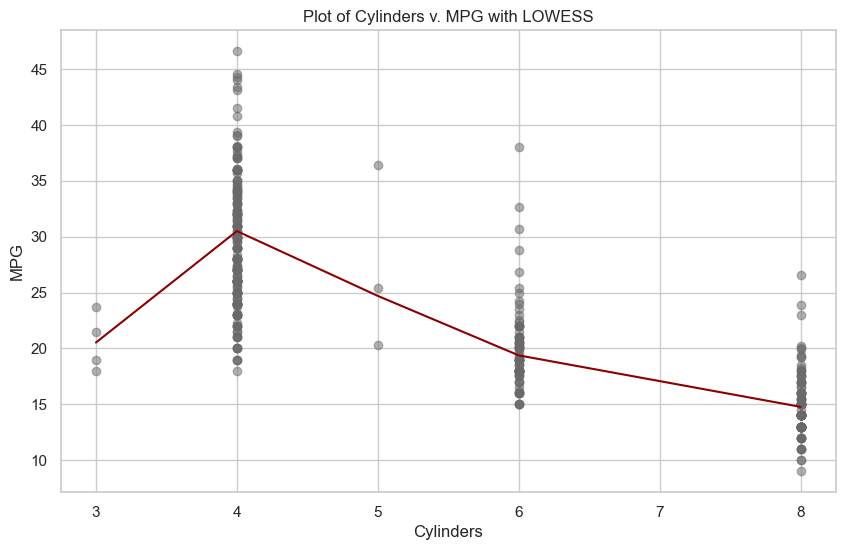

In [36]:
lowess_scatter(df, "Cylinders", "MPG", jitter=0.00, skip_lowess=False)

The scatter plot supports our hypothesis. We see that as the number of cylinders increase, the MPG decreases. This trend was indicated by the correlation coefficients, and the scatter plot confirms it.

1. Interestingly, the LOESS line indicates a drop in MPG for the 3 cylinder cars. 
2. This could be due to 3 cylinders being an inefficient setup.
3. This could also be due to the 3 cylinder engines simply being underdeveloped and not as optimized as the more popular 4 cylinder engines.

<a id="MPG vs Displacement"></a>
## MPG vs Displacement

Displacement seems like it could be a strong explanatory variable for the different car MPG values. As we found when gathering domain knowledge, higher displacement roughly correlates to more power and lower fuel efficiency, so much so that displacement is commonly used in marketing to indicate the power of the engine. Referring back to our causal loop diagram, we expect MPG and Displacement to be somewhat strongly negatively correlated.

Here are the correlation coefficients.

In [37]:
print("r   = ", stats.pearsonr( df.MPG, df.Displacement)[0])
print("rho = ", stats.spearmanr( df.MPG, df.Displacement)[0])

r   =  -0.8051269467104585
rho =  -0.8552335882841172


Pearson's correlation coefficient, $r$, is -0.80 which indicates a strong negative relationship. Referring back to our causal loop diagram, this finding supports our hypothesis that Displacement and MPG are strongly negatively correlated. Spearman's is also at -0.85, indicating a strong negative relationship as well.

Here's a scatter plot of the variables with a LOWESS line.

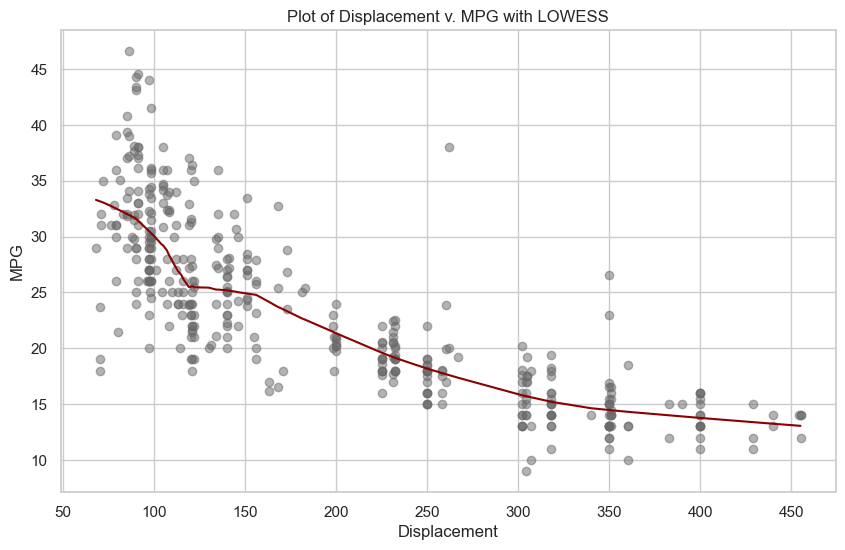

In [38]:
lowess_scatter(df, "Displacement", "MPG", jitter=0.00, skip_lowess=False)

The scatter plot supports our hypothesis. We see that as the displacement volume increases, the MPG decreases. This trend was indicated by the correlation coefficients, and the scatter plot confirms it.

1. We notice that a majority of displacement values are centered in the 100-150 ci range.
2. There are a couple of values that seem somewhat extreme, such as the value around 265 ci with 37 mpg.
3. This relationship doesn't quite seem linear, as the LOESS line has a clear curve to it.

<a id="MPG vs Horsepower"></a>
## MPG vs Horsepower

Horsepower seems like it could be a strong explanatory variable for the different car MPG values. Referring back to our causal loop diagram, we know that more cylinders and higher displacement result in more horsepower. Since we have already seen that Cylinders and Displacement are strongly negatively correlated with MPG, it follows that Horsepower should also be strongly negatively correlated with MPG.

Here are the correlation coefficients.

In [39]:
print("r   = ", stats.pearsonr( df.MPG, df.Horsepower)[0])
print("rho = ", stats.spearmanr( df.MPG, df.Horsepower)[0])

r   =  -0.7784267838977776
rho =  -0.8536164024453882


Pearson's correlation coefficient, $r$, is -0.78 which indicates a strong negative relationship. This finding supports our hypothesis that Horsepower and MPG are strongly negatively correlated. Spearman's is also at -0.85, indicating a strong negative relationship as well.

Here's a scatter plot of the variables with a LOWESS line.

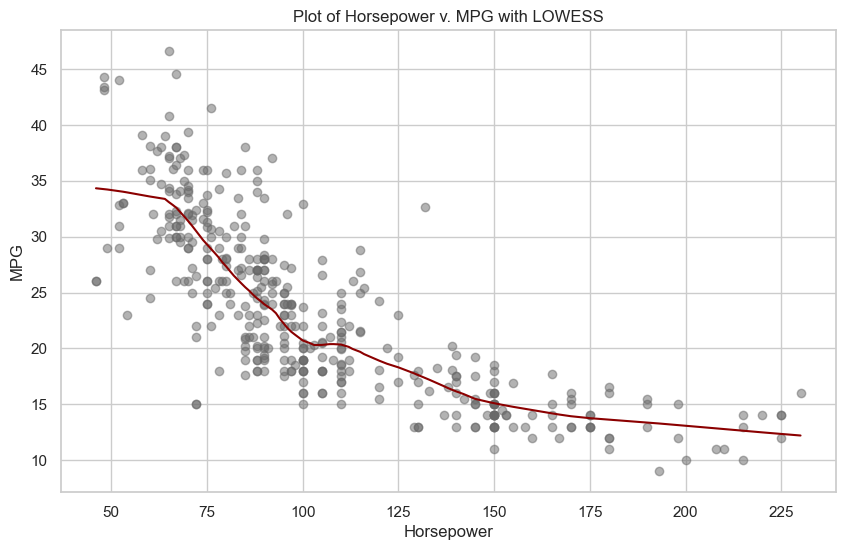

In [40]:
lowess_scatter(df, "Horsepower", "MPG", jitter=0.00, skip_lowess=False)

This scatter plot looks very similar to the previous scatter plot on Displacement vs MPG. The scatter plot supports our hypothesis. We see that as horsepower increases, the MPG decreases. This trend was indicated by the correlation coefficients, and the scatter plot confirms it.

1. These results plus our domain knowledge suggest that Horsepower and Displacement should be very strongly positively correlated.
2. Horsepower should also be strongly positively correlated to Cylinders as well.
3. This relationship doesn't quite seem linear, as the LOESS line has a clear curve to it.

<a id="MPG vs Weight"></a>
## MPG vs Weight

Weight seems like it could be a moderately strong explanatory variable for the different car MPG values. Referring back to our causal loop diagram, we hypothesize that as weight increases, MPG decreases, meaning that they are negatively correlated.

Here are the correlation coefficients.

In [41]:
print("r   = ", stats.pearsonr( df.MPG, df.Weight)[0])
print("rho = ", stats.spearmanr( df.MPG, df.Weight)[0])

r   =  -0.8322442148315756
rho =  -0.8755851198739869


Pearson's correlation coefficient, $r$, is -0.83 which indicates a strong negative relationship. This finding supports our hypothesis that Weight and MPG are moderately negatively correlated, and even goes beyond a "moderate" correlation and indicates a strong correlation, exceeding our expectations. Spearman's is also at -0.87, indicating a strong negative relationship as well.

Here's a scatter plot of the variables with a LOWESS line.

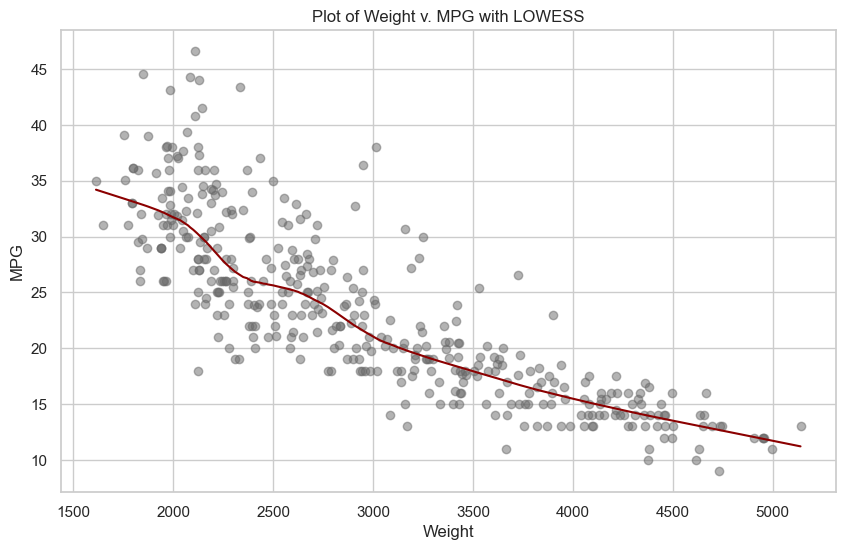

In [42]:
lowess_scatter(df, "Weight", "MPG", jitter=0.00, skip_lowess=False)

This scatter plot looks very similar to the previous two scatter plots on Displacement vs MPG and Horsepower vs MPG. The scatter plot supports our hypothesis. We see that as weight increases, the MPG decreases. This trend was indicated by the correlation coefficients, and the scatter plot confirms it.

1. These results plus our domain knowledge suggest that weight should be strongly positively correlated to Horsepower, Displacement and even cylinders.
2. It would make sense that cars with bigger engines with more cylinders are heavier and produce more horsepower and have larger displacements.
3. This relationship seems more linear than the previous two plots, but there is still a definite curve to the LOESS line.

<a id="MPG vs Acceleration"></a>
## MPG vs Acceleration

Acceleration seems like it could be a moderately strong explanatory variable for the different car MPG values. Referring back to our causal loop diagram, we hypothesize that as acceleration increases, MPG decreases, meaning that they are negatively correlated.

Here are the correlation coefficients.

In [43]:
print("r   = ", stats.pearsonr( df.MPG, df.Acceleration)[0])
print("rho = ", stats.spearmanr( df.MPG, df.Acceleration)[0])

r   =  0.4233285369027873
rho =  0.44153885845636487


<!-- Pearson's correlation coefficient, $r$, is -0.83 which indicates a strong negative relationship. This finding supports our hypothesis that Weight and MPG are moderately negatively correlated, and even goes beyond a "moderate" correlation and indicates a strong correlation, exceeding our expectations. Spearman's is also at -0.87, indicating a strong negative relationship as well.

Here's a scatter plot of the variables with a LOWESS line. -->

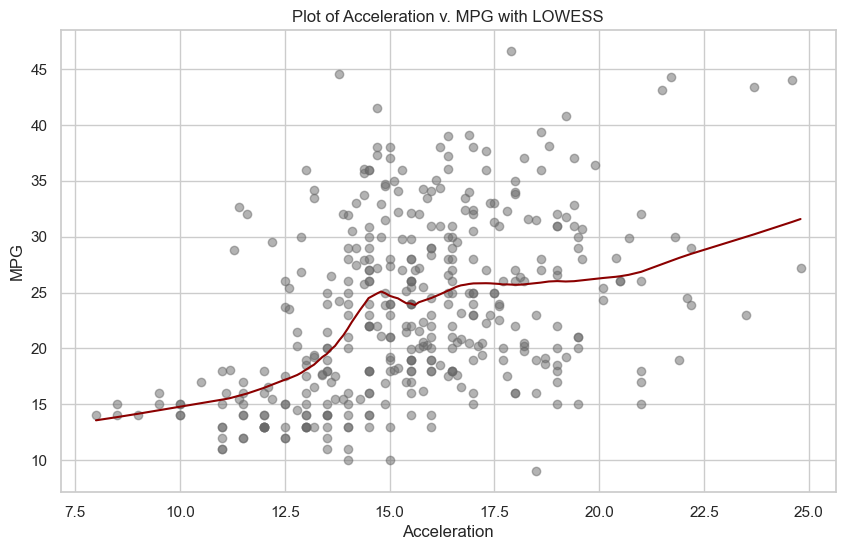

In [44]:
lowess_scatter(df, "Acceleration", "MPG", jitter=0.00, skip_lowess=False)

<!-- This scatter plot looks very similar to the previous two scatter plots on Displacement vs MPG and Horsepower vs MPG. The scatter plot supports our hypothesis. We see that as weight increases, the MPG decreases. This trend was indicated by the correlation coefficients, and the scatter plot confirms it.

1. These results plus our domain knowledge suggest that weight should be strongly positively correlated to Horsepower, Displacement and even cylinders.
2. It would make sense that cars with bigger engines with more cylinders are heavier and produce more horsepower and have larger displacements.
3. This relationship seems more linear than the previous two plots, but there is still a definite curve to the LOESS line. -->

<a id="MPG vs Model_Year"></a>
## MPG vs Model_Year

Model Year seems like it could be a weak to moderate explanatory variable for the different car MPG values. Referring back to our causal loop diagram, we hypothesize that as model year increases, MPG increases, meaning that they are positively correlated.

Here are the correlation coefficients.

In [45]:
print("r   = ", stats.pearsonr( df.MPG, df.Model_Year)[0])
print("rho = ", stats.spearmanr( df.MPG, df.Model_Year)[0])

r   =  0.5805409660907845
rho =  0.5748408744472727


Pearson's correlation coefficient, $r$, is 0.58 which indicates a moderate positive relationship. This finding supports our hypothesis that Model Year and MPG are moderately positively correlated. Spearman's is also at 0.57, indicating a moderate positive relationship as well.

Here's a scatter plot of the variables with a LOWESS line.

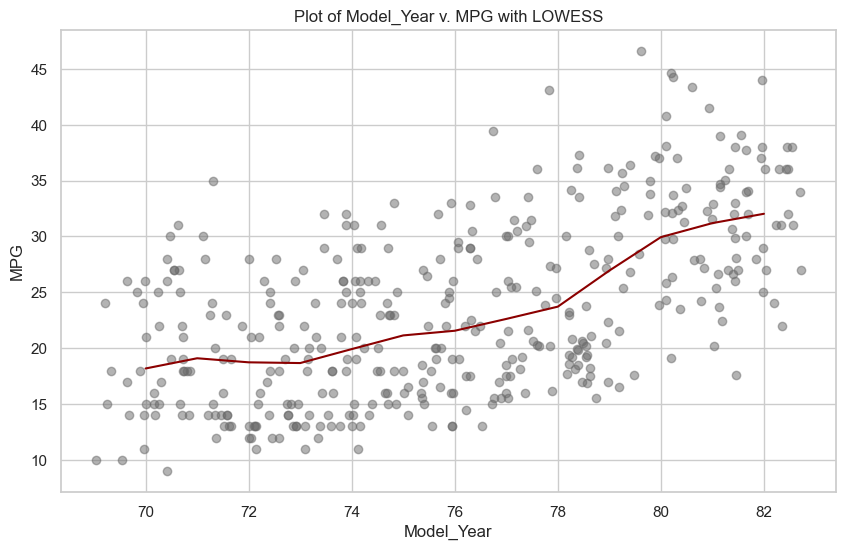

In [46]:
lowess_scatter(df, "Model_Year", "MPG", jitter=0.01, skip_lowess=False)

The scatter plot supports our hypothesis. We see that as Model Year increases, the MPG increases. The trend is clear. This trend was indicated by the correlation coefficients, and the scatter plot confirms it.

1. The LOESS line increases throughout it's length.
2. The data does not quite seem linear, as there seems to be an uptick in MPG starting in year 1980.
3. It is possible that something happened in 1980 such as a technological breakthrough or a shift in consumer/manufacturer attitude towards fuel efficiency.

<a id="MPG vs Origin"></a>
## MPG vs Origin

Origin seems like it could have some effect on vehicle MPG. It is possible that the different continents of origin have different priorities or manufacturing techniques that result in higher or lower MPG values. However, it is difficult to predict which origins would have higher or lower MPG values.

Here are the summary statistics for MPG by Origin.

In [47]:
describe_by_category(df, "MPG", "Origin", transpose=True)

Origin           1          2          3
count   245.000000  68.000000  79.000000
mean     20.033469  27.602941  30.450633
std       6.440384   6.580182   6.090048
min       9.000000  16.200000  18.000000
25%      15.000000  23.750000  25.700000
50%      18.500000  26.000000  31.600000
75%      24.000000  30.125000  34.050000
max      39.000000  44.300000  46.600000


Interestingly, we see that the cars made in the USA have by far the lowest mean MPG values, with a mean of 20.0. In second is Europe with a mean MPG of 27.6, and in third is Asia with a mean MPG of 30.5. We mentioned earlier that we might expect the USA to have the least efficient vehicles, but we were unsure. After seeing these statistics, it is clear that this was true.

Here is a scatter plot of MPG vs. Origin.

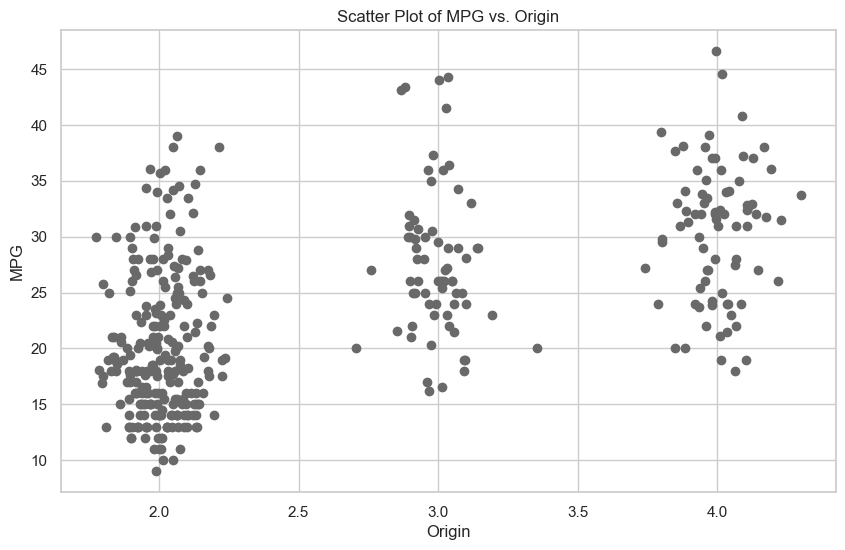

In [48]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
jitter = np.random.normal(1, 0.10, size=len(df.MPG))

axes.scatter(df.Origin + jitter, df.MPG, marker="o", color="dimgray")

axes.set_ylabel("MPG")
axes.set_xlabel("Origin")
axes.set_title("Scatter Plot of MPG vs. Origin")

plt.show()
plt.close()

We clearly see the strong effect that Origin has on MPG. We see that the American cars have much lower MPG values, followed by Europe, then Asia with the most fuel efficient cars.

We can also chart histograms of MPG for each Origin.

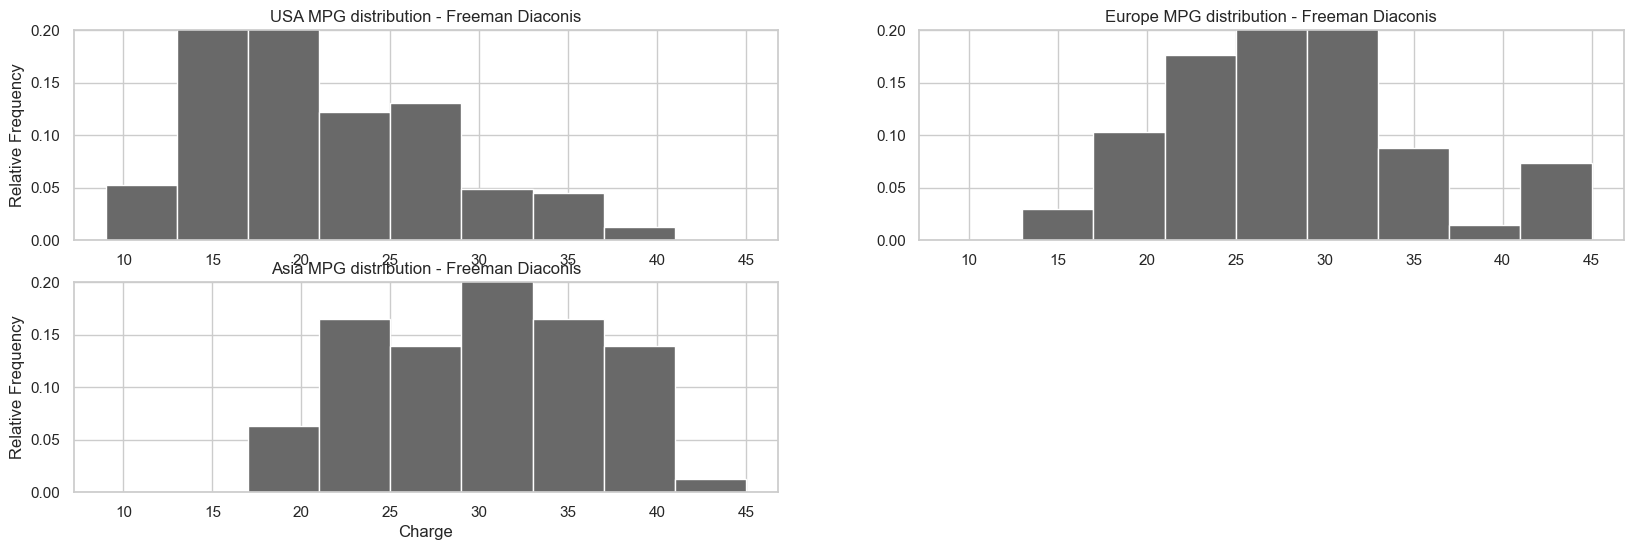

In [49]:
h = freeman_diaconis(df.MPG)
mn = int(df.MPG.min())
mx = int(df.MPG.max())
bins = [i for i in range( mn, mx, h)]

grouped = df.groupby("Origin")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(2, 2, 1)
observations = len(grouped["MPG"].get_group(1))
empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()

axes.hist(grouped["MPG"].get_group(1),bins=bins,color="dimgray", weights=empirical_weights)
axes.set_title("USA MPG distribution - Freeman Diaconis")
axes.set_ylim((0,0.2))
axes.set_ylabel("Relative Frequency")

axes = figure.add_subplot(2, 2, 2)
observations = len(grouped["MPG"].get_group(2))
empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()
axes.hist(grouped["MPG"].get_group(2),bins=bins,color="dimgray", weights=empirical_weights)
axes.set_title("Europe MPG distribution - Freeman Diaconis")
axes.set_ylim((0,0.2))

axes = figure.add_subplot(2, 2, 3)
observations = len(grouped["MPG"].get_group(3))
empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()
axes.hist(grouped["MPG"].get_group(3),bins=bins,color="dimgray", weights=empirical_weights)
axes.set_title("Asia MPG distribution - Freeman Diaconis")
axes.set_xlabel("Charge")
axes.set_ylim((0,0.2))
axes.set_ylabel("Relative Frequency")

plt.show()
plt.close()

The histograms clearly show that Origin has a strong effect on MPG. The USA MPG distribution is very skewed towards lower MPG values compared to the others. The Europe MPG distribution is centered closer to the 25-30 range, and the Asia MPG distribution is centered in the 30+ MPG range.

1. We see that Origin has a strong effect on MPG values, but what is it about the cars in these Origins that result in different MPG values?
2. We can reasonably assume from domain knowledge that the USA focuses on muscle cars, and prioritize acceleration and performance over fuel economy.
3. Could it also be that American cars are bigger and therefore heavier than the Asian and European cars?
4. Is this the same for Europe compared to Asia? Do the European cars prioritize performance or size more than Asia does?

<a id="MPG vs Car_Name"></a>
## MPG vs Car_Name

Car Name should be an interesting variable. However, it is difficult to make predictions about how this variable effects MPG due to the sheer number of different Car Names we saw during our single variable EDA. 

Here is a chart of MPG by Car_Name.

/var/folders/_n/9knjn8xn5td0pmwp2jsthnqw0000gn/T/ipykernel_36534/2700871377.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=45)


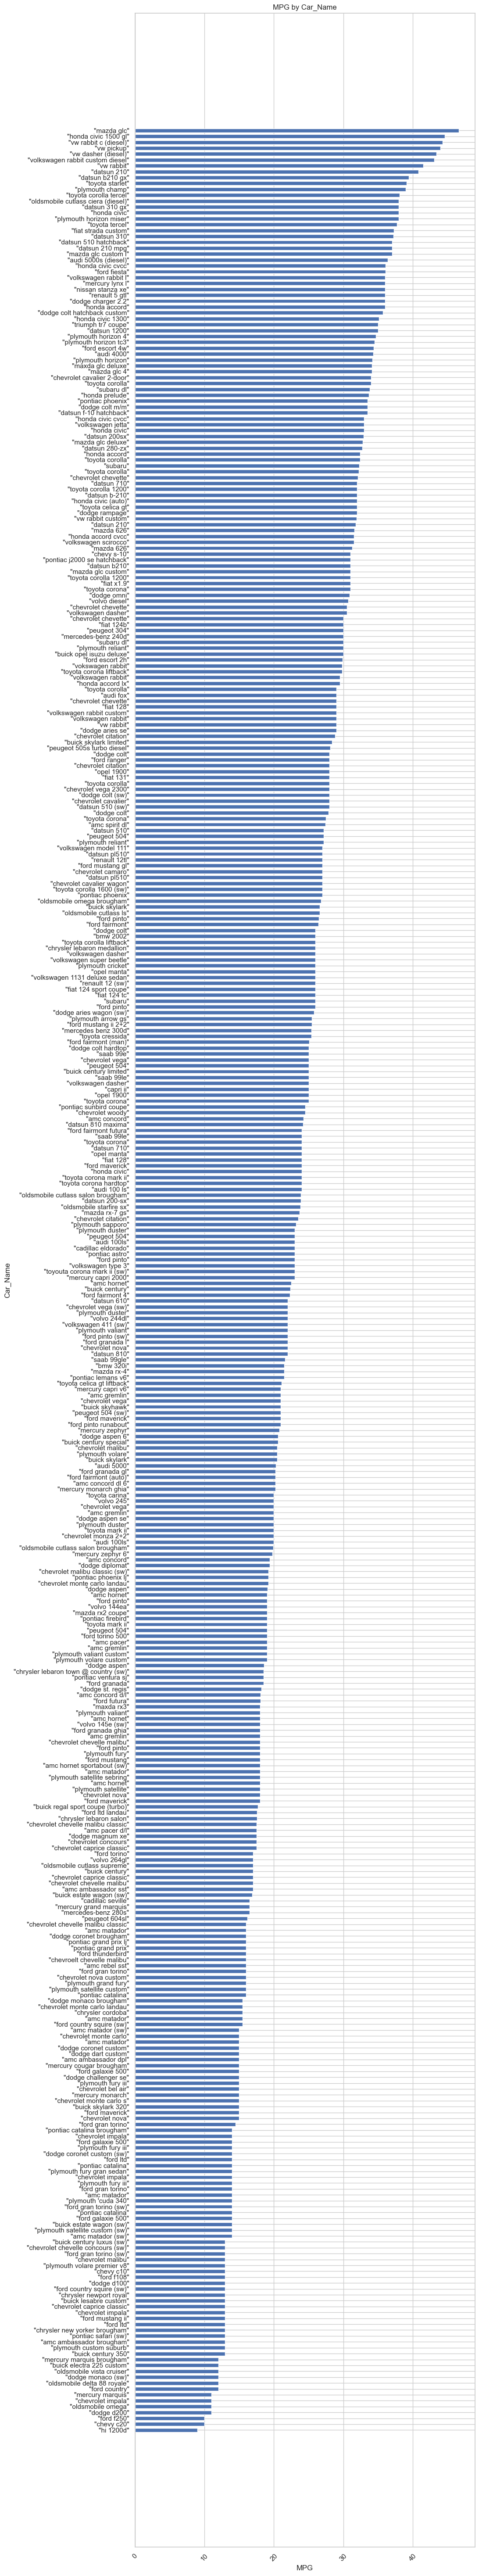

In [50]:
sorted_df = df.sort_values(by='MPG')

width = 1/1.5

figure = plt.figure(figsize=(10, 75)) # first element is width, second is height.

axes = figure.add_subplot(1, 1, 1)

axes.set_title( "MPG by Car_Name")
axes.barh(range(0, len(sorted_df)), sorted_df.MPG, width, align="center")
axes.set_yticks(range(0, len(sorted_df)))
axes.set_yticklabels(sorted_df.Car_Name)
axes.set_ylabel("Car_Name")
axes.set_xlabel("MPG")
axes.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))
axes.set_xticklabels(axes.get_xticklabels(), rotation=45)

plt.show()

It is difficult to extract meaning from this chart, as there are simply too many different Car Names. We see a large variety of diffent MPGs over a large and steady gradient.

1. We could get more information from the Car_Name variable if we extracted the manufacturer from each Car_Name.
2. If we had the manufacturer names, then we could see which manufacturers made the most efficient cars.
3. If we had manufacturer names, they would each correlate to a different Origin, which would make for an interesting relationship.

<a id="Digging Deeper"></a>
## Digging Deeper

Now that we're done with our initial EDA, we can dig deeper into questions we have unearthed.

One particularly interesting question we found was related to the "Make" of the cars. We want to add a new column to our dataframe called "Make", where we include the make of the car, which we extract from the Car_Name variable. Since the make always comes first in the Car_Name, this is a relatively straightforward operation.

In [51]:
df['Make'] = df['Car_Name'].str.split().str[0].str.strip('"')
corrections = {
    'chevroelt': 'chevrolet',
    'vokswagen': 'volkswagen',
    'maxda': 'mazda',
    'toyouta': 'toyota',
}
df['Make'] = df['Make'].replace(corrections)

df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Origin,Car_Name,Make
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu""",chevrolet
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320""",buick
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite""",plymouth
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst""",amc
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino""",ford


Now that we have added our "Make" column, let's check some preliminary statistics.

In [52]:
df.Make.value_counts()

ford             48
chevrolet        44
plymouth         31
dodge            28
amc              27
toyota           26
datsun           23
buick            17
pontiac          16
volkswagen       16
honda            13
mazda            12
mercury          11
oldsmobile       10
fiat              8
peugeot           8
audi              7
vw                6
chrysler          6
volvo             6
saab              4
opel              4
subaru            4
renault           3
chevy             3
cadillac          2
mercedes-benz     2
bmw               2
capri             1
hi                1
mercedes          1
triumph           1
nissan            1
Name: Make, dtype: int64

We see that Ford and Chevrolet are the most common makes, which makes sense because they are both American cars and we saw that the USA Origin was the most common. 

Now let's see which makes are the most fuel efficient. We expect to see mostly Asian cars towards the top and American cars at the bottom.

In [53]:
average_mpg_per_make = df.groupby('Make')['MPG'].mean()
sorted_average_mpg = average_mpg_per_make.sort_values(ascending=False)
sorted_average_mpg

Make
vw               39.016667
nissan           36.000000
triumph          35.000000
honda            33.761538
datsun           31.113043
subaru           30.525000
mazda            30.058333
renault          29.666667
volkswagen       29.150000
fiat             28.912500
toyota           28.165385
audi             26.714286
opel             25.750000
mercedes         25.400000
capri            25.000000
saab             23.900000
bmw              23.750000
peugeot          23.687500
mercedes-benz    23.250000
dodge            22.060714
plymouth         21.703226
volvo            21.116667
oldsmobile       21.100000
chevrolet        20.370455
pontiac          20.012500
cadillac         19.750000
ford             19.475000
buick            19.182353
mercury          19.118182
amc              18.070370
chevy            18.000000
chrysler         17.266667
hi                9.000000
Name: MPG, dtype: float64

Our hypothesis holds true, as the top of the list is dominated by Asian car manufacturers such as Nissan, Honda, Subaru, Mazda and Toyota. There are also some European cars towards the top like VW, Renault, Wolkswagen, Fiat and Audi.

Meanwhile, the bottom of the list is mostly American car manufacturers such as Chrysler, Chevy, AMC, Mercury, Buick, Ford, Cadillac, Pontiac, Chevrolet and Oldsmobile.

Interestingly, we see that VW, Nissan and Triumph are the most fuel efficient makes. However, we also see that Nissan and Triumph each only had one car in the data. Honda is the most popular car with high fuel efficiency.

## 1.3 <a id="step3">Null & Distributional Models</a>
<a href="#Predictive Model">Predictive Model</a><br>
<a href="#Data Generating Story">Data Generating Story</a><br>
<a href="#Distribution Model">Distribution Model</a><br>
<a href="#Question 1">Question 1</a><br>
<a href="#Question 2">Question 2</a><br>
<a href="#Question 3">Question 3</a>

<a id="Predictive Model"></a>
## Predictive Model

We want to be able to predict the MPG of a randomly selected car from this time period.

To create our predictive model, we first define our loss function. We intend for overestimates and underestimates to be treated symmetrically, and for large errors to be given more weight than small errors. Thus, we choose our loss function to be Mean Squared Error. Because we have chosen Mean Squared Error to be our loss function, and the constant model that will minimize MSE is the mean, we choose the mean as our constant model.

To create a mean model for our car data, we can take the mean value generated from our descriptive statistics above for the MPG variable. We can recalculate the mean as follows.

In [54]:
car_predict = np.mean(df.MPG)
print(car_predict)

23.445918367346938


We find that the mean MPG of our data is 23.4. As a predictive model, we can say that the MPG of a random car from the same time period will get about 23.4 mpg.

In order to provide error bounds on our prediction, we have two options. If the data is approximately normally distributed, we can put bounds on our error of 1.96 standard deviations from the mean. If they are not, we can use Chebyshev's inequality, which states that $1 - \frac{1}{k^2}$ percent of the data must be within $k$ standard deviations from the mean. 

Since the MPG data seems to be approximately normally distributed (not necessarily actually normally distributed), we will use 1.96 standard deviations from the mean as our error bounds. 

We recalculate the standard deviation of the data as follows.

In [55]:
car_std = np.std(df.MPG)
print(car_std)

7.795045762682583


We find that the standard deviation of our data is 7.79.

Now we can calculate our error bounds.

In [56]:
car_error = car_std * 1.96
print(car_error)

car_predict, car_predict - car_error, car_predict + car_error

15.278289694857863


(23.445918367346938, 8.167628672489075, 38.7242080622048)

Thus, we can say that our mean model predicts that a random car will get 23.4 mpg, with a 95% chance of it getting between 8.17 and 38.72 mpg.

<a id="Data Generating Story"></a>
## Data Generating Story

The MPG that a given car gets is determined by many different factors, including engine displacement, number of cylinders, weight and aerodynamics. Thus, we can say that the MPG of a car is determined by the combination of many different effects. We predict that the MPG variable approximately follows a normal distribution. If a normal distribution is not a good fit, we will also try a log-normal distribution, which we suspect may also be a good fit since the MPG data is slightly skewed to the left.

<a id="Distribution Model"></a>
## Distribution Model

We want to be able to answer questions such as "what is the percent chance that a car gets more than 25 mpg?". Another example of a question we want to ask is "what is the percent chance that a car gets between 25 and 30 mpg?" These types of questions go beyond the capabilities of the null predictor we calculated above. In order to be able to answer these more complex questions, we want to find a mathematical distribution that approximates our data as closely as possible. 

The normal distribution has two parameters, which happen to be the first and second moments of the empirical distribution. These are the mean and standard devation of the empirical data, which we have already calculated.

We start by plotting the normal distribution with these parameters over the empirical distribution to check the fit.

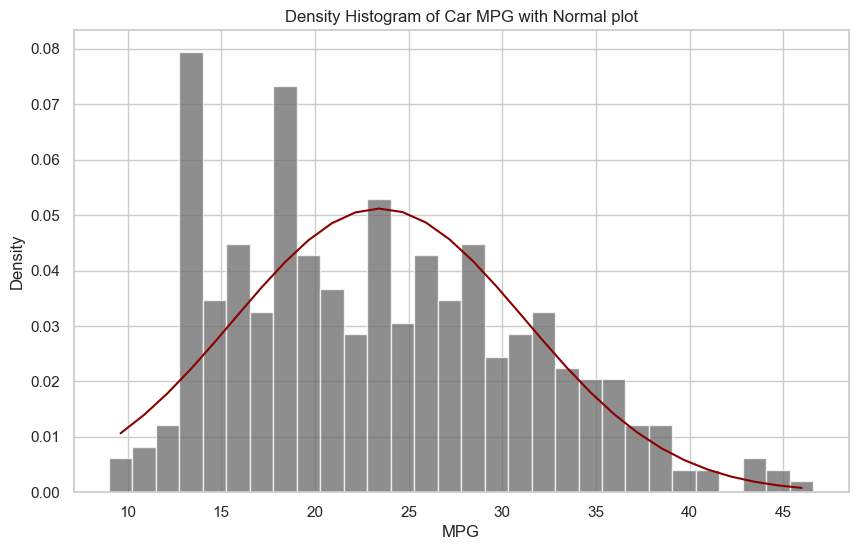

In [57]:
# df = df.drop_duplicates(subset='Car_Name')


figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(df.MPG, color="DimGray", density=True, bins=30, alpha=0.75)
axes.set_xlabel( "MPG")
axes.set_ylabel( "Density")
axes.set_title("Density Histogram of Car MPG with Normal plot")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]    

car_mean = np.mean(df.MPG)
car_std  = np.std(df.MPG)
ys = [norm.pdf( k, loc=car_mean, scale=car_std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()

Interestingly, the normal distribution looks like a good fit for our data, with the exception of two of the boxes that seem to jump out over the overlayed distribution.

Now we will check how well the Normal distribution fits our empirical data. To do this, we generatively create data using the Normal distribution formula with the parameters from our empirical data. Then we plot the cumulative difference between the generated data and the empirical data.

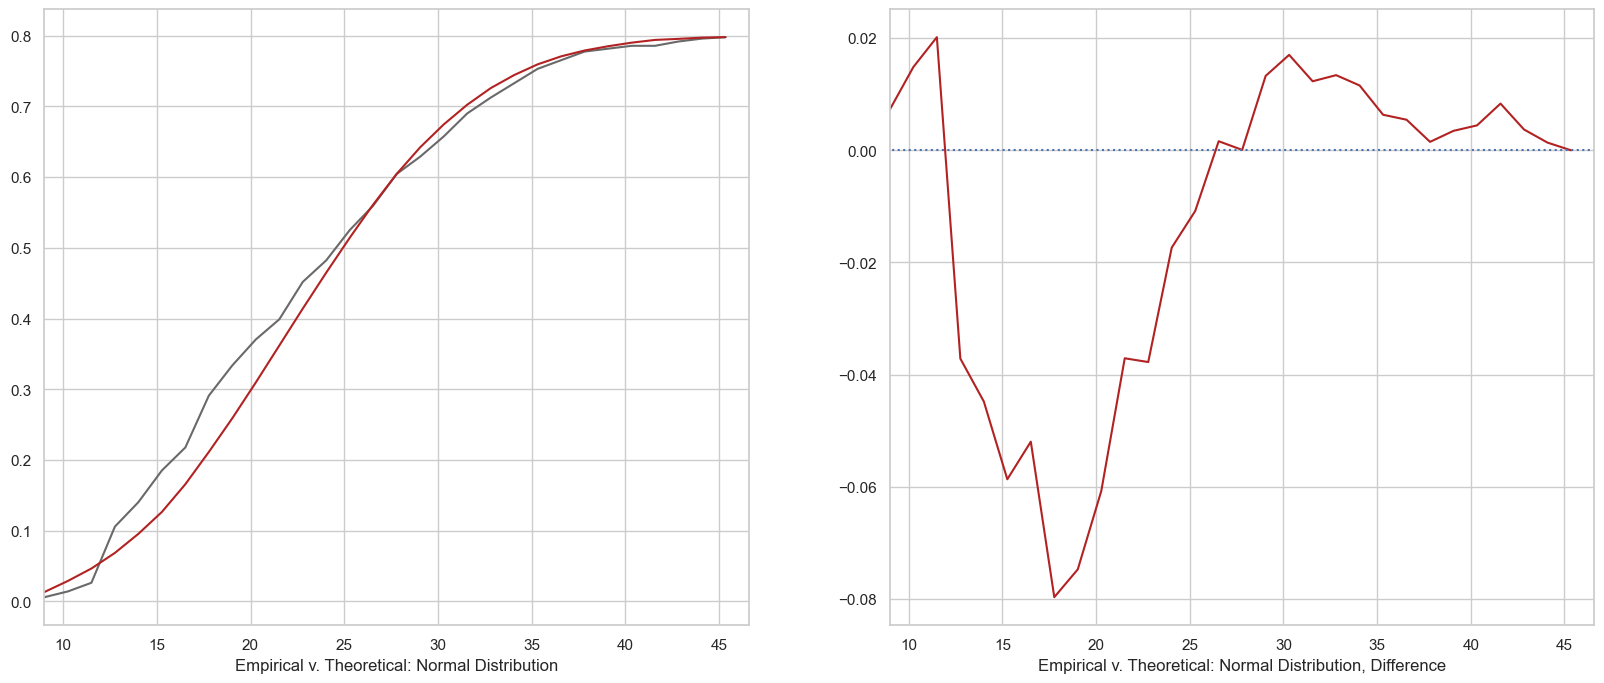

In [58]:
figure = plt.figure(figsize=(20, 8))

car_mn = np.min(df.MPG)
car_mx = np.max(df.MPG)
mean = np.mean(df.MPG)
std = np.std(df.MPG)

axes = figure.add_subplot(1, 2, 1)

values, base = np.histogram(df.MPG, bins=30, density=True)
cumulative = np.cumsum(values)
axes.plot(base[:-1], cumulative, color="dimgray")
axes.set_xlim((car_mn, car_mx))

sampled_data = [mean + r * std for r in np.random.standard_normal(10000)]
values2, base = np.histogram(sampled_data, bins=base, density=True)
cumulative2 = np.cumsum(values2)
axes.plot( base[:-1], cumulative2, color="firebrick")
axes.set_xlim((car_mn, car_mx))
axes.set_xlabel( "Empirical v. Theoretical: Normal Distribution")

axes = figure.add_subplot(1, 2, 2)

differences = cumulative2 - cumulative
axes.plot(base[:-1], differences, color='firebrick')
axes.set_xlim((car_mn, car_mx))
axes.hlines(0, 0, 14000, linestyles="dotted")
axes.set_xlabel( "Empirical v. Theoretical: Normal Distribution, Difference")

plt.show()
plt.close()

We see that the empirical data (black) lines up pretty well with the theoretical distribution (red). We see that the theoretical distribution underpredicts in the range of about 15-25mpg, which is where we observed the histogram boxes pop above the distribution. This would be expected. But other than that, the fit looks good and we can say that the normal distribution is a good model for our data.

<a id="Question 1"></a>
## Question 1

What is the probability of a random car getting more than 35 mpg?

We expect this percentage to be relatively low, since 35 is on the higher end of car MPG based on our histogram and descriptive statistics.

In [59]:
mean = np.mean(df.MPG)
std  = np.std(df.MPG)

norm.sf(35, mean, std)

0.06913902526282042

Our distributional model predicts that there is only a 6.9% chance that a random car will get more than 35 mpg. This result supports our hypothesis, as relatively few cars get at least 35 mpg.

<a id="Question 2"></a>
## Question 2

What is the probability of a random car getting fewer than 20 mpg?

We expect this percentage to be relatively small, but greater than 20% since our histogram shows that there are still a good number of cars that get below 20 mpg.

In [60]:
norm.cdf(20, mean, std)

0.3292210174153037

Our distributional model predicts that there is a 33% chance that a random car will get fewer than 20 mpg. This result supports our hypothesis, as a decent number of cars in the sample get fewer than 20 mpg.

<a id="Question 3"></a>
## Question 3

What is the probability of a random car getting between 25 and 30 mpg?

We expect this percentage to be relatively low, since 25-30 is a small range.

In [61]:
norm.cdf(30, mean, std) - norm.cdf(25, mean, std)

0.22075776146628523

Our model predicts that there is a 22% chance that a random car will get between 25 and 30 mpg. This finding is consistent with our expectation, as this is a relatively narrow range, but there are still plenty of cars that have MPG values in this range.